In [1]:
# Imports (add)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme()

In [2]:
# Import data into Pandas DataFrame
filename = 'Tesla Battery Survey.xlsx'
df = pd.read_excel(filename, sheet_name="All entries")  # Use suitable method and parameters

### Data preparation

In [3]:
len(df)

1535

In [88]:
vehicle_age = pd.DataFrame(df['Date you charged to 100%']-df['Manufacture date'], columns=["vehicle age"])
vehicle_age

,vehicle age
0,57 days
1,187 days
2,113 days
3,525 days
4,552 days
...,...
1530,76 days
1531,141 days
1532,3 days
1533,248 days


In [89]:
# Check if there are NaT values

vehicle_age[vehicle_age.isnull().any(axis=1)] # There are 4 entries with a null value

,vehicle age
249,NaT
830,NaT
974,NaT
1240,NaT


In [90]:
# Check for negative values

vehicle_age[vehicle_age["vehicle age"] < np.timedelta64(0, 'D')] # There are 14 cases with a negative value

,vehicle age
103,-58 days
104,-185 days
326,-282 days
1083,-255 days
1184,-1282 days
1185,-1138 days
1186,-31 days
1304,-175 days
1305,-36 days
1370,-91 days


We can conclude that `18` datapoint for vehicle age are not valid.

For each datapoint, use K column in sheet `Administrative` to assign *usable Wh capacity* for each model/configuration and enhance the dataset (create new column) with this parameter

In [7]:
wh_df = pd.read_excel(filename, sheet_name="Administrative", usecols=[5, 10])

In [8]:
wh_df

,Unnamed: 5,Usable battery capacity when new
0,NaN,NaN
1,NaN,Wh
2,Unspecified 85 kWh,77500
3,Model S 60,58500
4,Model S 60D,58500
...,...,...
113,NaN,NaN
114,NaN,NaN
115,NaN,NaN
116,NaN,NaN


In [9]:
wh_df.dropna(inplace=True)
wh_df.rename(columns={'Unnamed: 5' : 'Vehicle model', 'Usable battery capacity when new' : 'usuable Wh capacity'}, inplace=True)

In [10]:
wh_df

,Vehicle model,usuable Wh capacity
2,Unspecified 85 kWh,77500
3,Model S 60,58500
4,Model S 60D,58500
5,Model S 70,68800
6,Model S 70D,68800
7,Model S 75,73200
8,Model S 75D,73200
9,Model S 85,77500
10,Model S P85,77500
11,Model S P85+,77500


In [11]:
df.drop(columns=['Select Username', 'Unnamed: 24', 'Trendline'], inplace=True)

In [12]:
df = pd.merge(df, wh_df, on='Vehicle model')

In [13]:
# Overview of the DataFrame
df.loc[0].describe

<bound method NDFrame.describe of Timestamp                                                                       2015-06-10 03:15:00.288000
Username                                                                                              220v
Region                                                                Europe (excluding UK) & Asia Pacific
Range unit                                               km. My car displays range in kilometres and I ...
Manufacture date                                                                       2015-04-14 00:00:00
Vehicle model                                                                                   Model S 85
Supercharge frequency                                                                                Never
100% charge frequency                                                                        Twice a month
Frequency of 5% or less range                                                                        Never
Dai

For each datapoint, calculate the number of equivalent full cycles (how many times the usable Wh capacity has been used) experienced by the battery based on individual driving history. Start by calculating cumulated energy use (in Wh) per vehicle. Example: A vehicle with 75 kWh usable capacity has consumed a total of 6,000 kWh after 80 equivalent full cycles.

In [14]:
cycles = (df['Lifetime average [Wh/mi or Wh/km]?']*df['Your mileage [mi or km]'])/df['usuable Wh capacity']
cycles = cycles.dropna()

In [15]:
cycles = np.floor(cycles)
cycles

0         9
1        68
2        12
3       124
4       133
       ... 
1529     31
1530      8
1531     18
1532      1
1534      8
Length: 1462, dtype: object

### Analysis

We define `z` as the Relative Range of the vehicle compared to the day it was purchased (column `Remaining battery capacity`). `z_actual` refers to a real measurement and `z_pred` to an output from a predictive model. We defince `x` as vehicle age in years.

In [16]:
z = df['Remaining battery capacity']
x = vehicle_age['vehicle age'].dt.days/365

In [17]:
z = z.apply(lambda x: 1 if (x > 1) else x)

1. How many unique vehicles/users are represented in the dataset?

In [18]:
unique_users = df['Username'].str.lower() # case insensitive
unique_users.dropna(inplace=True)

In [19]:
unique_users.drop_duplicates(inplace=True)

In [20]:
print("The dataset contains {0} unique users.".format(len(unique_users)))

The dataset contains 602 unique users.


In [21]:
unique_vehicles = df[['Username', 'Vehicle model', 'Manufacture date']]
unique_vehicles['Username'] = unique_vehicles['Username'].apply(str.lower)
unique_vehicles.drop_duplicates(inplace=True)

C:\Users\Gianlorenzo\AppData\Local\Temp\ipykernel_6980\2498031980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_vehicles['Username'] = unique_vehicles['Username'].apply(str.lower)
C:\Users\Gianlorenzo\AppData\Local\Temp\ipykernel_6980\2498031980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_vehicles.drop_duplicates(inplace=True)


In [22]:
print("The dataset contains {0} unique vehicles.".format(len(unique_vehicles)))

The dataset contains 658 unique vehicles.


2. What is the count of different reported models (group by Model S/X/3/Other - not detailed configuration)? Example: Model S: 1000, Model X: 1000, Model 3: 50, Other: 30.

In [23]:
# Split vehicle model string to discard vehicle configuration
vehicles = pd.DataFrame(df['Vehicle model'].str.split().str[0]+ ' ' + df['Vehicle model'].str.split().str[1])

In [24]:
vehicles.groupby(by=['Vehicle model']).value_counts()

Vehicle model
Model 3             60
Model S           1400
Model X             51
Unspecified 85      24
dtype: int64

3. Create line plot with Relative Range against vehicle age in years (z_actual vs x) for the vehicle with largest number of datapoints recorded. It should look something like this

In [25]:
max = dict(df.groupby(by=['Username', 'Vehicle model'])['Vehicle model'].value_counts())
i = list(max.items())
i.sort(key = lambda x: x[1])
print(i[-1])

(('jpet', 'Model S P85D', 'Model S P85D'), 46)


In [91]:
users = pd.DataFrame(columns=['vehicle age', 'relative range'])

In [92]:
z_actual_user = df[['Username', 'Remaining battery capacity']]

In [93]:
z_actual_user = z_actual_user.loc[z_actual_user['Username'] == 'jpet']

In [94]:
z_actual_user = z_actual_user['Remaining battery capacity']

In [95]:
x_users = vehicle_age['vehicle age'].loc[z_actual_user.index].dt.days/365

In [96]:
x_users

881    0.038356
882    0.068493
883    0.093151
884    0.101370
885    0.153425
886    0.169863
887    0.323288
888    0.347945
889    0.350685
890    0.446575
891    0.457534
892    0.457534
893    0.457534
894    0.558904
895    0.558904
896    0.558904
897    0.594521
898    0.594521
899    0.882192
900    0.884932
901    1.005479
902    1.010959
903    1.021918
904    1.054795
905    1.180822
906    1.191781
907    1.249315
908    1.328767
909    1.328767
910    1.328767
911    1.345205
912    1.438356
913    1.479452
914    1.482192
915    1.575342
916    1.687671
917    1.728767
918    1.882192
919    1.939726
920    2.128767
921    2.339726
922    2.350685
923    2.402740
924    2.495890
925    2.728767
926    2.747945
Name: vehicle age, dtype: float64

In [97]:
out = x_users.to_frame().join(z_actual_user)

In [98]:
out.sort_values(by=['vehicle age'], inplace=True)

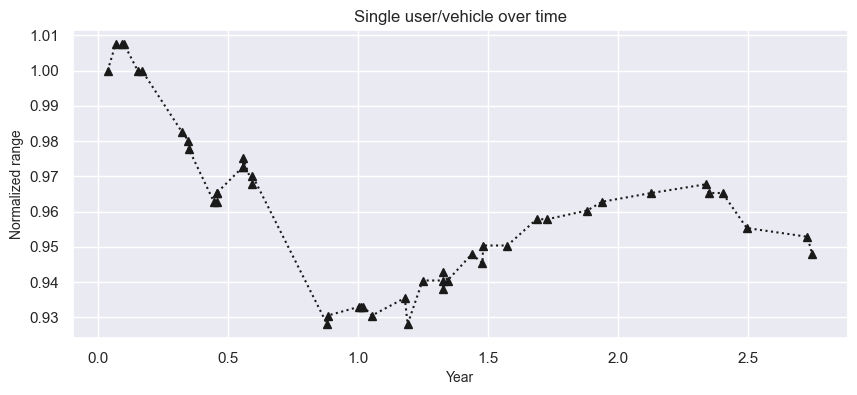

In [99]:
fig = plt.figure(figsize=(10,4))
plt.plot(out['vehicle age'], out['Remaining battery capacity'], '^k:');
plt.title('Single user/vehicle over time', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Normalized range', fontsize=10)
plt.show()

4. Create scatter plot with Relative Range against vehicle age in years (z_actual vs x) for all data points (all vehicles). The plot should look something like this

In [26]:
range_age = pd.DataFrame(columns=['vehicle age', 'relative range'])

In [27]:
range_age['vehicle age'] = x
range_age['relative range'] = z

In [28]:
range_age.dropna(inplace=True)
range_age = range_age[range_age['vehicle age'] >= 0]

In [29]:
range_age

,vehicle age,relative range
0,0.156164,1.000000
1,0.512329,0.987755
2,1.408219,0.992405
3,3.690411,0.898734
4,4.095890,0.946835
...,...,...
1530,0.095890,0.989170
1531,0.400000,1.000000
1532,0.816438,0.977273
1533,1.115068,0.945455


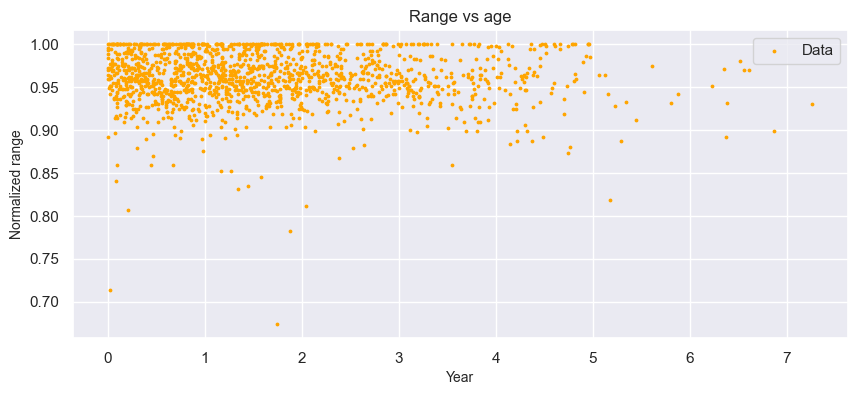

In [30]:
fig = plt.figure(figsize=(10,4))
plt.scatter(range_age['vehicle age'], range_age['relative range'], s=3, c='orange', label='Data');
plt.title('Range vs age', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Normalized range', fontsize=10)
plt.legend()
plt.show()

In [31]:
range_age

,vehicle age,relative range
0,0.156164,1.000000
1,0.512329,0.987755
2,1.408219,0.992405
3,3.690411,0.898734
4,4.095890,0.946835
...,...,...
1530,0.095890,0.989170
1531,0.400000,1.000000
1532,0.816438,0.977273
1533,1.115068,0.945455


In [32]:
x = range_age['vehicle age']
y = range_age['relative range']
slope, intercept, r, p, std_err = stats.linregress(x, y)

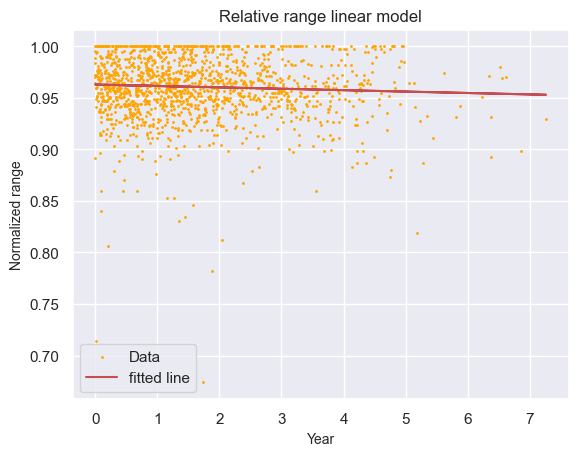

In [33]:
plt.title('Relative range linear model', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Normalized range', fontsize=10)
plt.scatter(x, y, s=1, c='orange', label='Data');
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()

In [34]:
z_pred = slope * x + intercept
z_pred

0       0.962813
1       0.962326
2       0.961101
3       0.957980
4       0.957426
          ...   
1530    0.962895
1531    0.962480
1532    0.961910
1533    0.961502
1534    0.961112
Name: vehicle age, Length: 1517, dtype: float64

Plot distribution (histogram plot) of model estimation errors (z_actual - z_pred)

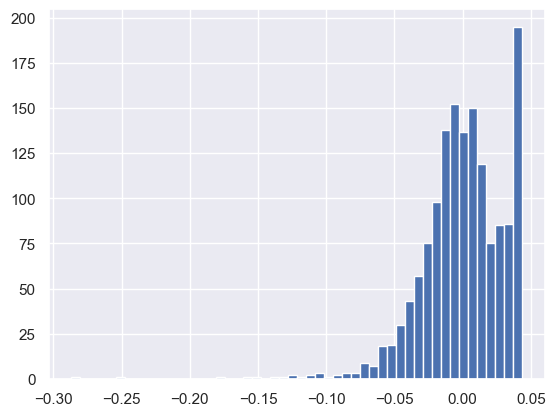

In [35]:
# Distribution of model estimation error
z_actual = y

plt.hist(z_actual-z_pred, bins=50);

In [36]:
print(std_err)

0.0006166518150282792


Calculate standard error (standard deviation) of the Relative Range estimates

In [37]:
print(np.std(z_pred))

0.0017575459036970667
